# Analysis of the MIMIC-III Dataset

## Abstract
[words here! also results!]

## Introduction

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, publicly available database composed of health information related to deidentified patients admitted to critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012. [Johnson, 2016 ; https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4878278/] This database has been utilized by researchers across the globe to study patient critical care outcomes, develop predictive models, and apply machine learning techniques to analyze patient health data. [citations needed]

MIMIC-III is a relational database consisting of 26 tables. [Johnson, 2016 ; https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4878278/] This database includes detailed infomration such as patient demographics, vital signs, laboratory results, and diagnoses.  [need to find papers that use the MIMIC-III database] The rich depth and scope of the dataset have enabled advancements in the fields of medical research and artificial intelligence. [citation needed]

This study utilizes MIMIC-III version 1.4, which is the most current version of the database at the time of analysis. [Johnson, 2016 ; https://doi.org/10.13026/C2XW26] The analysis conducted in this journal explore distribution of patient demographics, time series analysis of ICU admission, and likelihood of patient readmission using detailed graphics and machine learning algorithms.

## Exploratory Data Analysis and Visualization

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from query import query_a, query_b, query_c, query_d, mapped_diagnosis

# TODO: currently working with the demo data. make sure to upload the full data when available!

### Age and Gender Distribution

In [10]:
### What are the age and gender distributions of patients admitted to the ICU?

df_a = query_a()
df_a['death_time'] = pd.Categorical(df_a['death_time'], categories=["death within hospital", "death within 90 days of discharge", "death not within 90 days of discharge"], ordered=True)
df_a['age'] = df_a['age'].apply(lambda x: 100 - x if x > 79 else x)

print(df_a.head())
df_a.info()

  gender  age      los  death_days                             death_time  \
0      F   71   1.6325         283  death not within 90 days of discharge   
1      F   36  13.8507           0                  death within hospital   
2      F   13   2.6499           0                  death within hospital   
3      F   76   2.1436        1196  death not within 90 days of discharge   
4      M   48   1.2938           0                  death within hospital   

   hospital_expire_flag  
0                     0  
1                     1  
2                     1  
3                     0  
4                     1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   gender                371 non-null    object  
 1   age                   371 non-null    int64   
 2   los                   371 non-null    float64 
 3   death_days  

According to overview of the data, we have gender and age information on patients, along with their length of stay and how long after hospital ICU admission their reported death was. The hospital expire flag notes whether the patient died within the hospital (1) or outside of the hospital (0). There are a total of 371 patient records in this set. Patients who were above the age of 79 at admission have had their ages obsurced for HIPAA and have an age of 300 years; these patient records were removed during the query process. The age column was adjusted to account for records with ages above 79 being removed from analysis; any ages, then, recorded above 79 are erroneous and must be adjusted. For instance, a 91-year-old patient would not have their age recorded as 91, but as 300. Likely, this means that there was a computing error in the year of birth and admittance year by a difference of 100, meaning this patient should be 9-years-old.

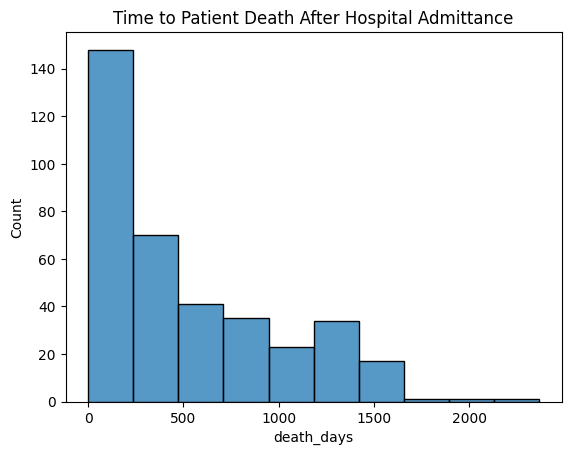

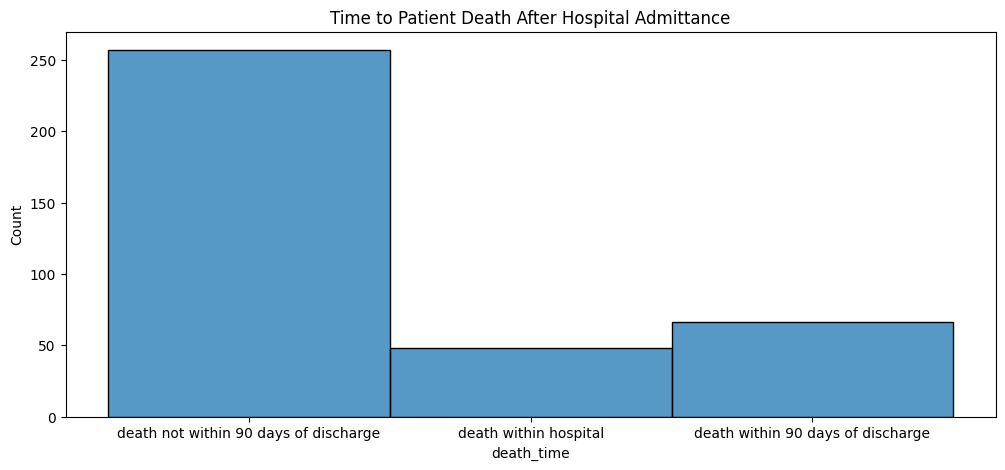

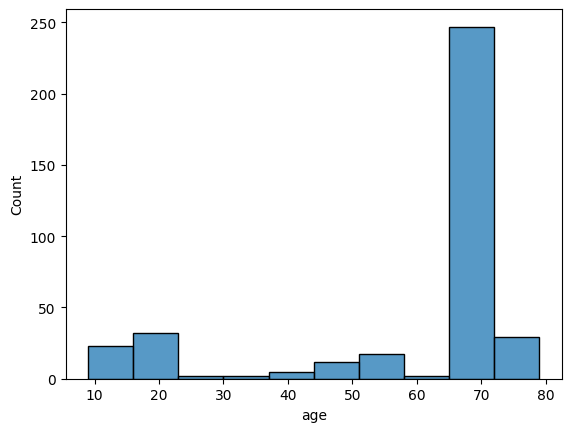

count    371.000000
mean      57.574124
std       18.849382
min        9.000000
25%       57.000000
50%       66.000000
75%       66.000000
max       79.000000
Name: age, dtype: float64


In [27]:
sns.histplot(df_a['death_days'], bins=10)
plt.title('Time to Patient Death After Hospital Admittance')
plt.show()

f, ax = plt.subplots(figsize = (12,5))

sns.histplot(df_a['death_time'])
plt.title('Time to Patient Death After Hospital Admittance')
plt.show()

sns.histplot(df_a['age'], bins=10)
plt.show()

print(df_a['age'].describe()) # print to md

The above plot is skewed right, suggesting that many of the patients admitted to the ICU do not die within even 250 days of hospital admittance. [talk about age] [discuss mortality rate; majority of patients do not die within the ICU]

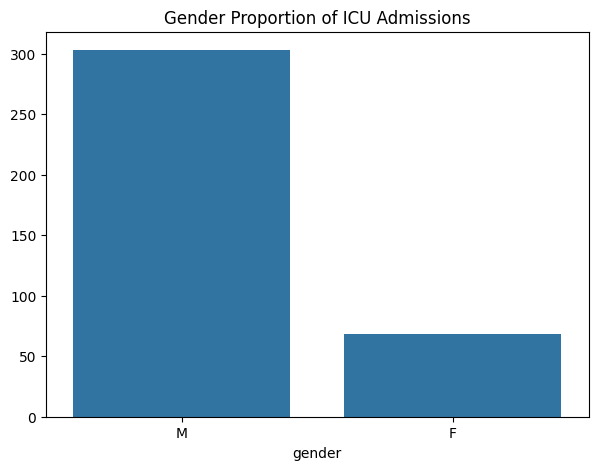

count     371
unique      2
top         M
freq      303
Name: gender, dtype: object


In [28]:
f, ax = plt.subplots(figsize = (7,5))
gender_counts = df_a['gender'].value_counts()
sns.barplot(x=gender_counts.index, y=gender_counts.values)
plt.title('Gender Proportion of ICU Admissions')
plt.show()

print(df_a['gender'].describe()) ## I don't want the describe function, but I want a table that spits out how many males + females are present in the data

The majority of the patients admitted to the ICU are male (%).

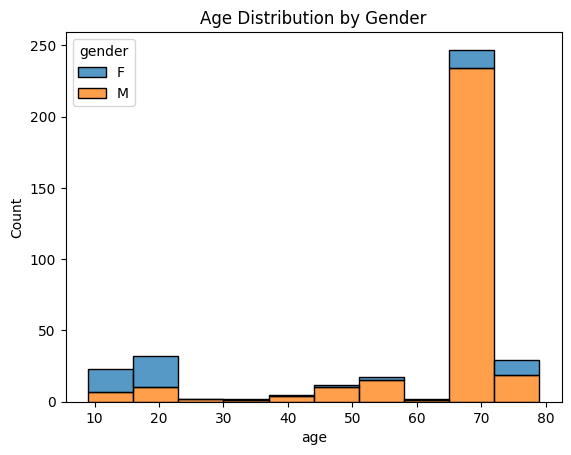

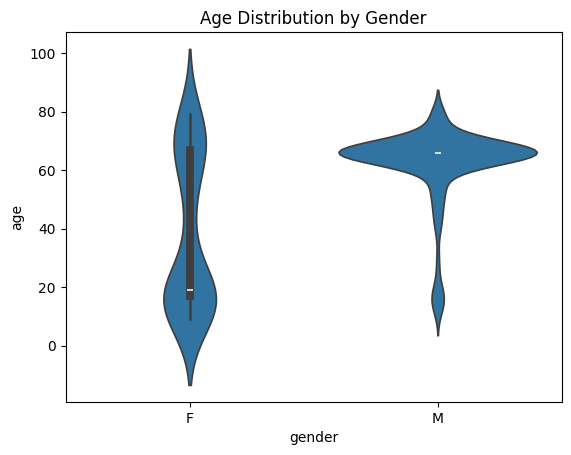

In [29]:
sns.histplot(data=df_a, x='age', hue='gender', multiple='stack', bins=10)
plt.title('Age Distribution by Gender')
plt.show()

sns.violinplot(x='gender', y='age', data=df_a)
plt.title('Age Distribution by Gender')
plt.show()

[age distribution of patients by gender]

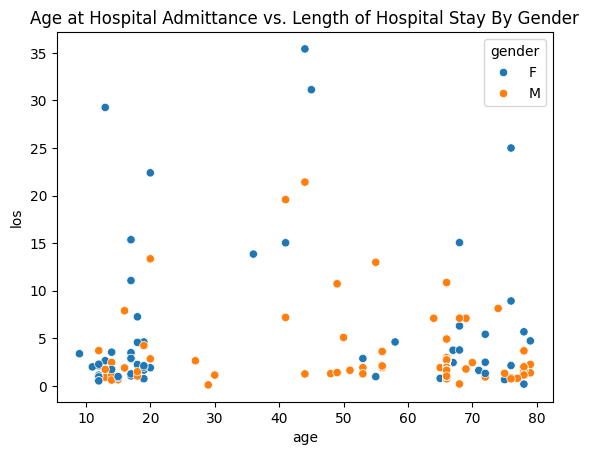

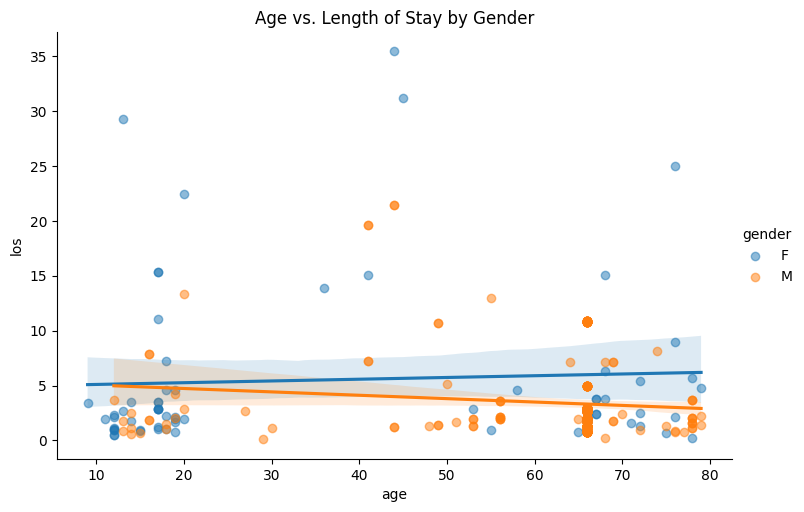

In [30]:
sns.scatterplot(x='age', y='los', hue = 'gender', data=df_a)
plt.title('Age at Hospital Admittance vs. Length of Hospital Stay By Gender')
plt.show()

sns.lmplot(x='age', y='los', hue='gender', data=df_a, aspect=1.5, scatter_kws={'alpha':0.5})
plt.title('Age vs. Length of Stay by Gender')
plt.show()

[remark about clusters + outliers in length of stay + implications of trend lines and their error bands]

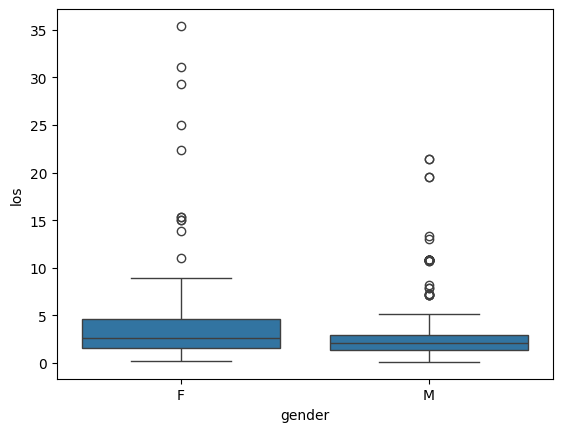

In [31]:
sns.boxplot(x='gender', y='los', data=df_a)
plt.show()

[females tend to have a longer stay at the ICU (can run mean + median), whereas males have shorter stays at the icu. is this due to males being more likely to die? or males being the majority of older patients? show more graphs below!]

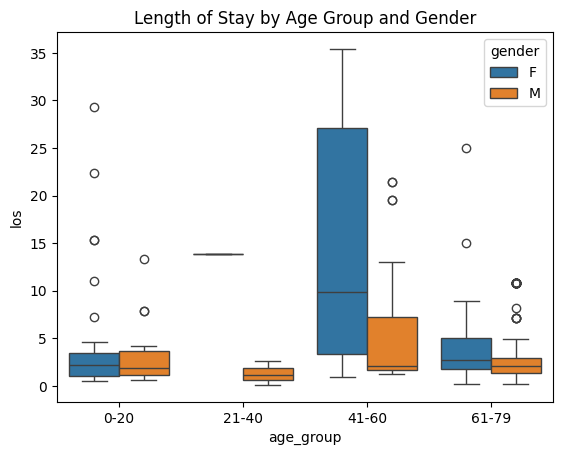

In [32]:
df_a['age_group'] = pd.cut(df_a['age'], bins=[0, 20, 40, 60, 80], labels=['0-20', '21-40', '41-60', '61-79'])
sns.boxplot(x='age_group', y='los', hue='gender', data=df_a)
plt.title('Length of Stay by Age Group and Gender')
plt.show()

[what plagues women in their 41-60s??? dude what.... anyways look at young adults 0-20yrs and how similar they are betewen men and women. what does this imply about men? what is the average los for men across all ages? why is it so rapidly different for women? what diagnoses do women in their 41-60s come in to the ICU for?]

### Demographic Analysis

In [3]:
### What are the demographics of patients admited to the ICU?
### What are the diagnoses of patients admitted to the ICU?
### What are the most common admission diagnoses for different age groups?
df_b = query_b()
df_b['death_time'] = pd.Categorical(df_b['death_time'], categories=["death within hospital", "death within 90 days of discharge", "death not within 90 days of discharge"], ordered=True)
df_b['age'] = df_a['age'].apply(lambda x: 100 - x if x > 79 else x)

print(df_b.head())
df_b.info()

  gender   age insurance  religion marital_status               ethnicity  \
0      F  71.0  Medicare  CATHOLIC      SEPARATED  BLACK/AFRICAN AMERICAN   
1      F  36.0   Private  CATHOLIC         SINGLE   UNKNOWN/NOT SPECIFIED   
2      F  13.0  Medicare  CATHOLIC           None   UNKNOWN/NOT SPECIFIED   
3      F  76.0  Medicare  CATHOLIC       DIVORCED                   WHITE   
4      M  48.0  Medicare  CATHOLIC       DIVORCED                   WHITE   

             diagnosis      los  death_days  \
0               SEPSIS   1.6325         283   
1          HEPATITIS B  13.8507           0   
2               SEPSIS   2.6499           0   
3     HUMERAL FRACTURE   2.1436        1196   
4  ALCOHOLIC HEPATITIS   1.2938           0   

                              death_time  hospital_expire_flag  
0  death not within 90 days of discharge                     0  
1                  death within hospital                     1  
2                  death within hospital                   

This query includes new information, including insurance type, religion, marital status, self-reported ethnicity, and ICU diagnosis. This data allows for analysis on patient demographics and admission diagnoses.

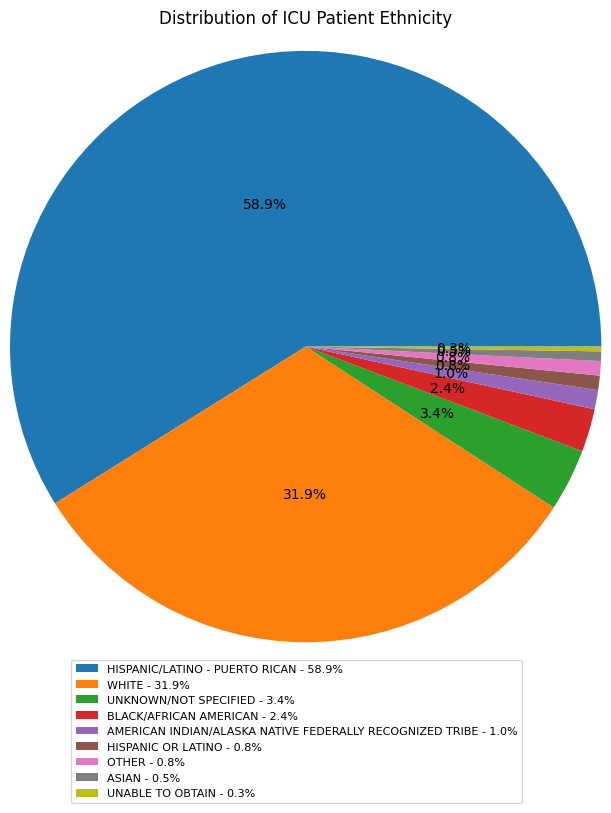

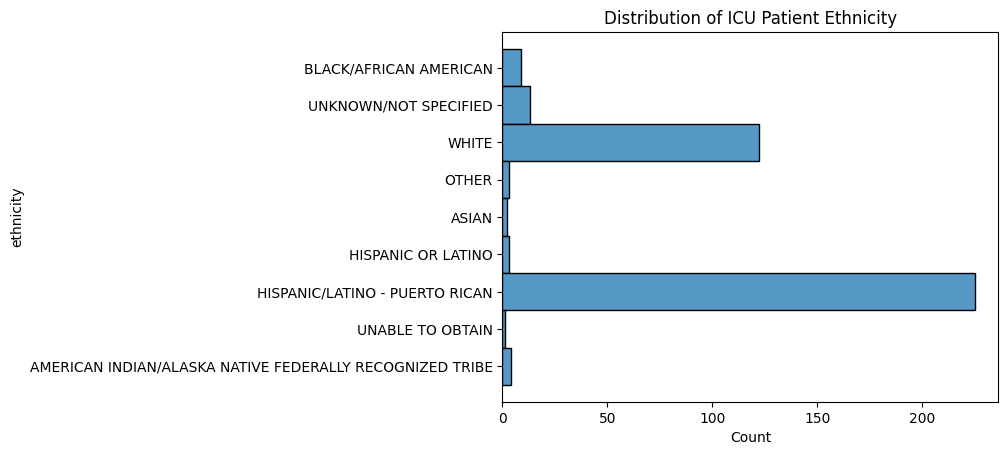

In [4]:
# I want a heat map lol
### TODO: DIAGNOSES ARE SEPARATED BY A SEMICOLON ; -- NEED TO SEPARATE THEM :(
eth_counts = df_b['ethnicity'].value_counts()
eth_labels = eth_counts.index
eth_percentages = eth_counts / eth_counts.sum() * 100

f, ax = plt.subplots()
patches, texts, autotexts = ax.pie(eth_counts, labels = None, autopct='%1.1f%%', pctdistance=0.5, radius = 2)
legend_labels = [f'{label} - {percentage:.1f}%' for label, percentage in zip(eth_labels, eth_percentages)]
plt.title(label = "Distribution of ICU Patient Ethnicity", pad = 20, y = 1.3)
plt.legend(patches, legend_labels, loc='lower right', fontsize=8, bbox_to_anchor=(1.1,-.75))
plt.show()

sns.histplot(y = df_b['ethnicity'])
plt.title('Distribution of ICU Patient Ethnicity')
plt.show()

[describe ethnicity of general patients in the ICU]

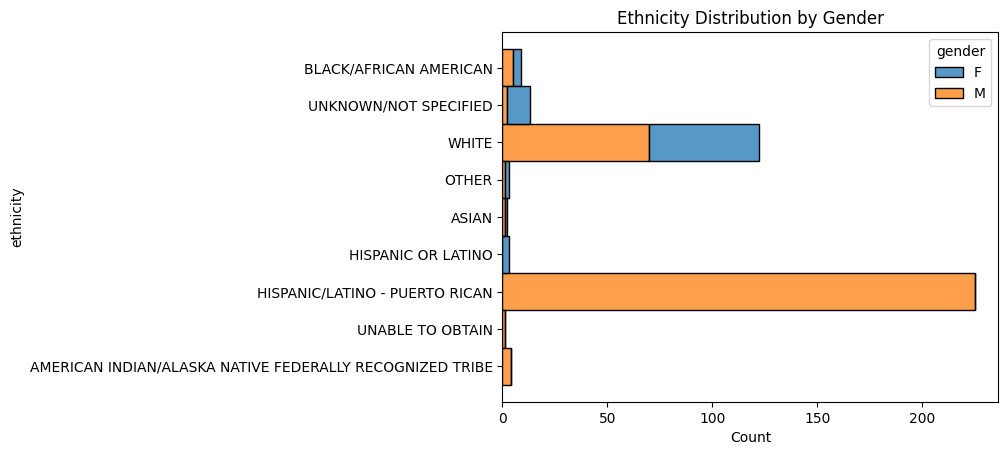

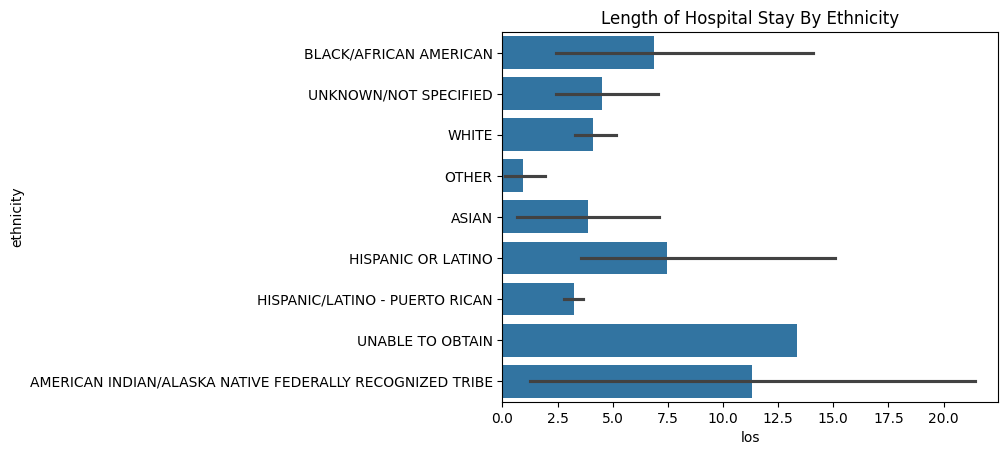

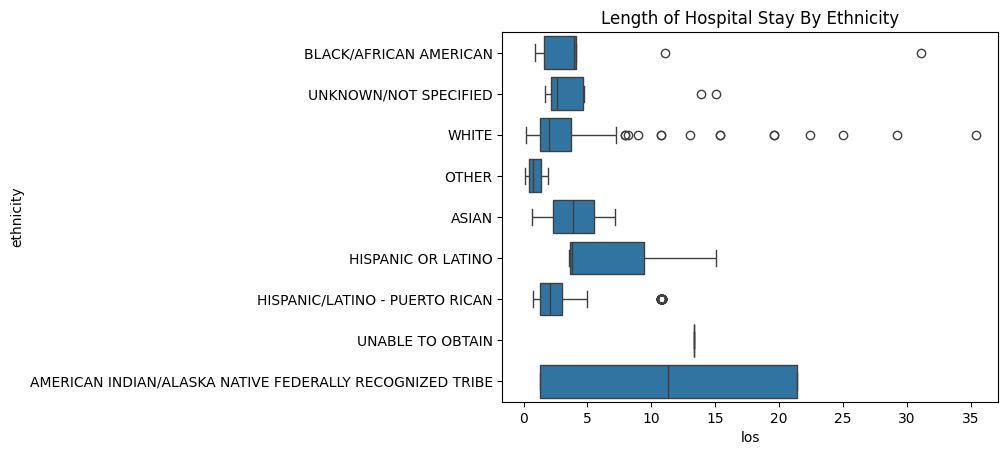

In [5]:
sns.histplot(data=df_b, y='ethnicity', hue='gender', multiple='stack')
plt.title('Ethnicity Distribution by Gender')
plt.show()

sns.barplot(y='ethnicity', x='los', data=df_b)
plt.title('Length of Hospital Stay By Ethnicity')
plt.show()

sns.boxplot(y='ethnicity', x='los', data=df_b)
plt.title('Length of Hospital Stay By Ethnicity')
plt.show()

[discuss variability and how a boxplot more clearly represents the data]

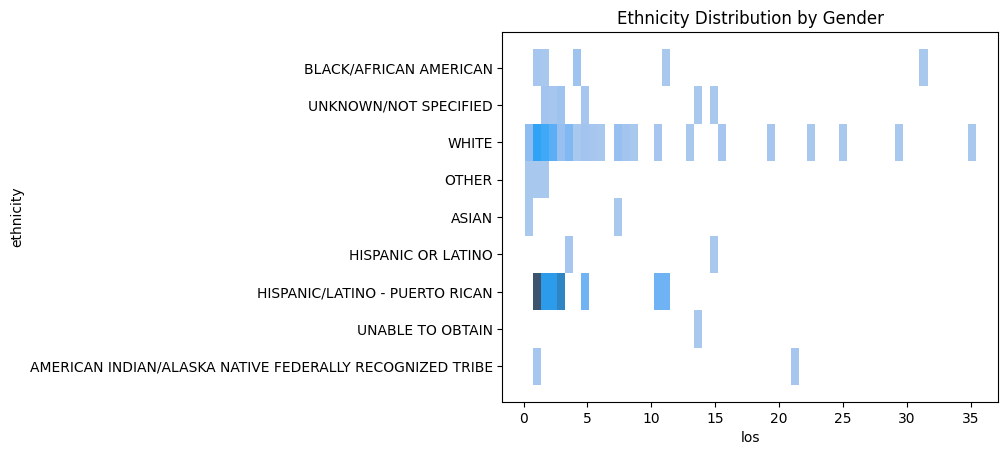

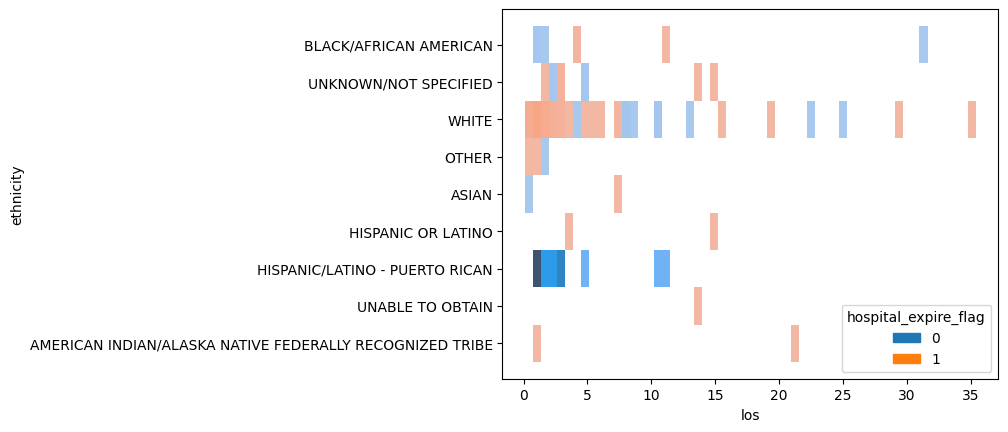

In [6]:
sns.histplot(data=df_b, y='ethnicity', x = 'los')
plt.title('Ethnicity Distribution by Gender')
plt.show()

ax = sns.histplot(data=df_b, y='ethnicity', x = 'los', hue = 'hospital_expire_flag', multiple='stack')
sns.move_legend(ax, loc = 'lower right')
plt.show()

[about above plots]

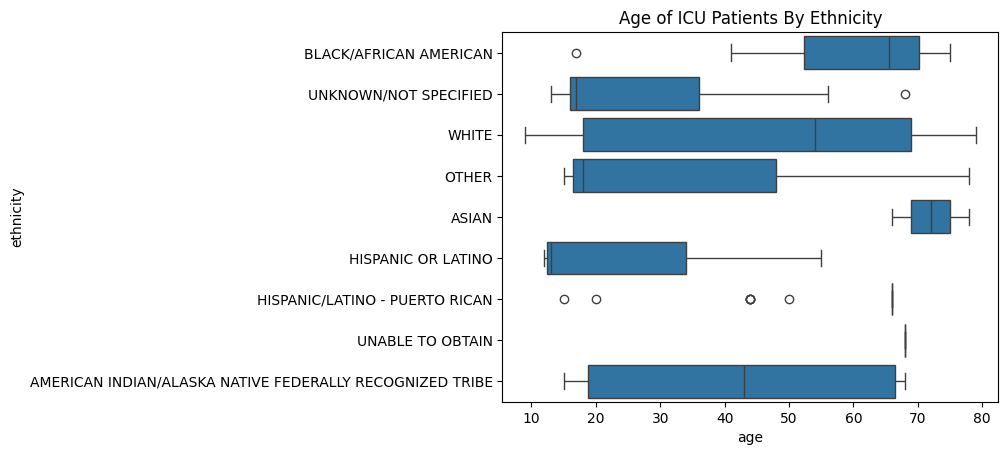

In [7]:
sns.boxplot(y='ethnicity', x='age', data=df_b)
plt.title('Age of ICU Patients By Ethnicity')
plt.show()

[about ages of patients]

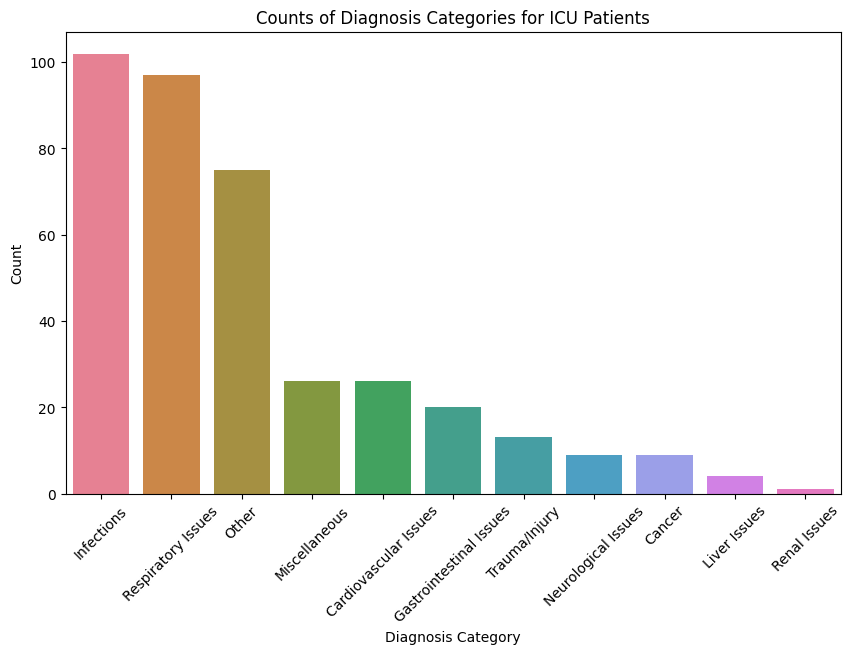

In [21]:
df_b['diagnosis_category'] = mapped_diagnosis(df_b['diagnosis'])
category_counts = df_b['diagnosis_category'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, hue = category_counts.index)
plt.title('Counts of Diagnosis Categories for ICU Patients')
plt.xlabel('Diagnosis Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

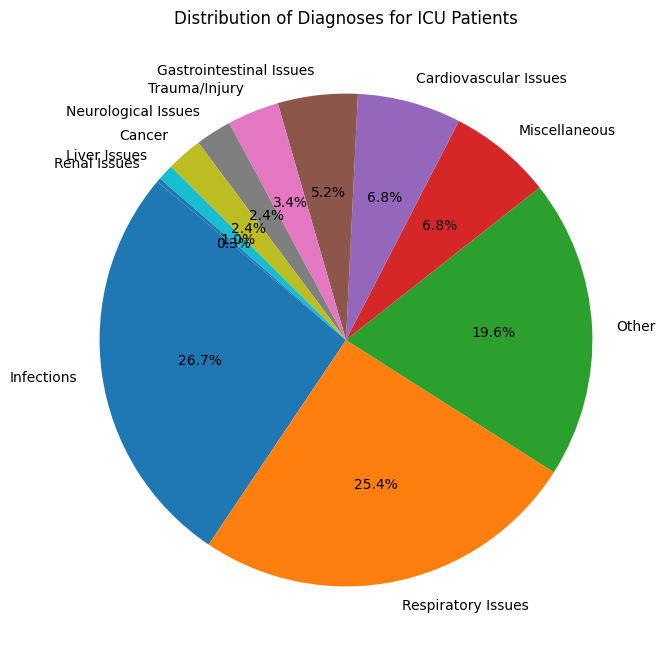

In [25]:
diagnosis_percentages = category_counts / category_counts.sum() * 100

plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Diagnoses for ICU Patients')
plt.show()


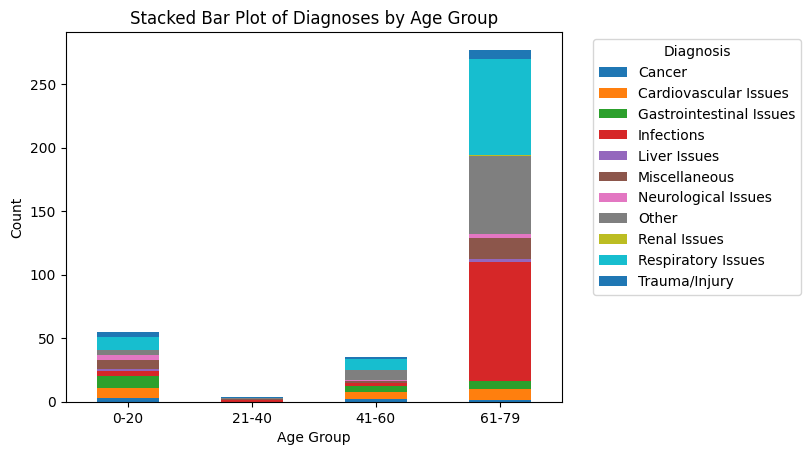

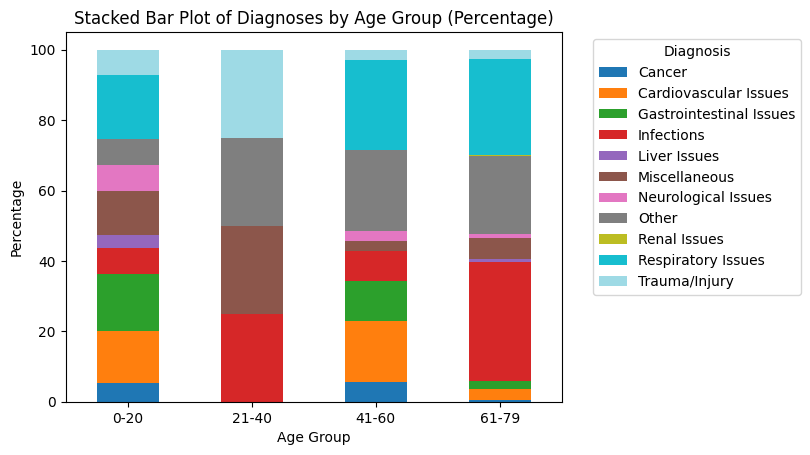

In [31]:
df_b['age_group'] = pd.cut(df_b['age'], bins=[0, 20, 40, 60, 80], labels=['0-20', '21-40', '41-60', '61-79'])
age_diagnosis_counts = df_b.groupby(['age_group', 'diagnosis_category'], observed = False).size().unstack().fillna(0)
age_diagnosis_percents = age_diagnosis_counts.div(age_diagnosis_counts.sum(axis=1), axis=0) * 100

age_diagnosis_counts.plot(kind='bar', stacked=True)
plt.title('Stacked Bar Plot of Diagnoses by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Diagnosis', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

age_diagnosis_percents.plot(kind='bar', stacked=True, colormap='tab20')
plt.title('Stacked Bar Plot of Diagnoses by Age Group (Percentage)')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.legend(title='Diagnosis', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

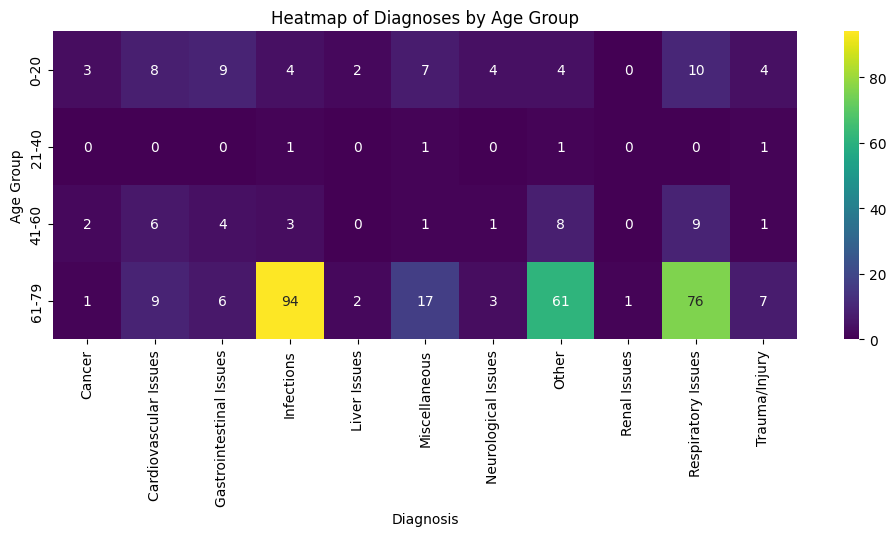

In [35]:
heatmap_data = df_b.pivot_table(index='age_group', columns='diagnosis_category', aggfunc='size', fill_value=0, observed = False)

plt.figure(figsize=(12, 4))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='d')
plt.title('Heatmap of Diagnoses by Age Group')
plt.xlabel('Diagnosis')
plt.ylabel('Age Group')
plt.show()

### Time Analysis

In [3]:
### How do patient outcomes vary by season or time of admission?
### Are there any seaonsal trends in specific diagnoses?
df_c = query_c()

print(df_c.head())
df_c.info()

             admittime insurance  religion marital_status  \
0  2164-10-23 21:09:00  Medicare  CATHOLIC      SEPARATED   
1  2126-08-14 22:32:00   Private  CATHOLIC         SINGLE   
2  2125-10-04 23:36:00  Medicare  CATHOLIC           None   
3  2149-05-26 17:19:00  Medicare  CATHOLIC       DIVORCED   
4  2163-05-14 20:43:00  Medicare  CATHOLIC       DIVORCED   

                ethnicity            diagnosis  hospital_expire_flag  
0  BLACK/AFRICAN AMERICAN               SEPSIS                     0  
1   UNKNOWN/NOT SPECIFIED          HEPATITIS B                     1  
2   UNKNOWN/NOT SPECIFIED               SEPSIS                     1  
3                   WHITE     HUMERAL FRACTURE                     0  
4                   WHITE  ALCOHOLIC HEPATITIS                     1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0 

Notice the error in computing the admission time in the dataset. For analysis purposes, years such as "2149" were converted to their 20th century counterpart, like "1949". The addition of a datetime column to our query allows for time series analysis to be conducted: were ICU admissions more common in the daytime or nighttime? Is there a season that sees more ICU admissions than others?

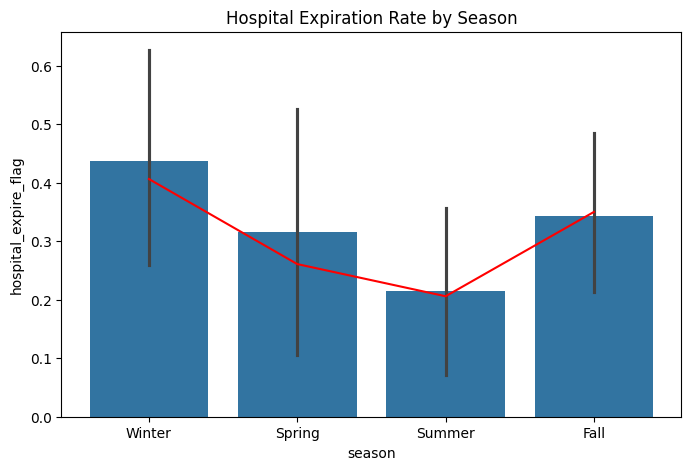

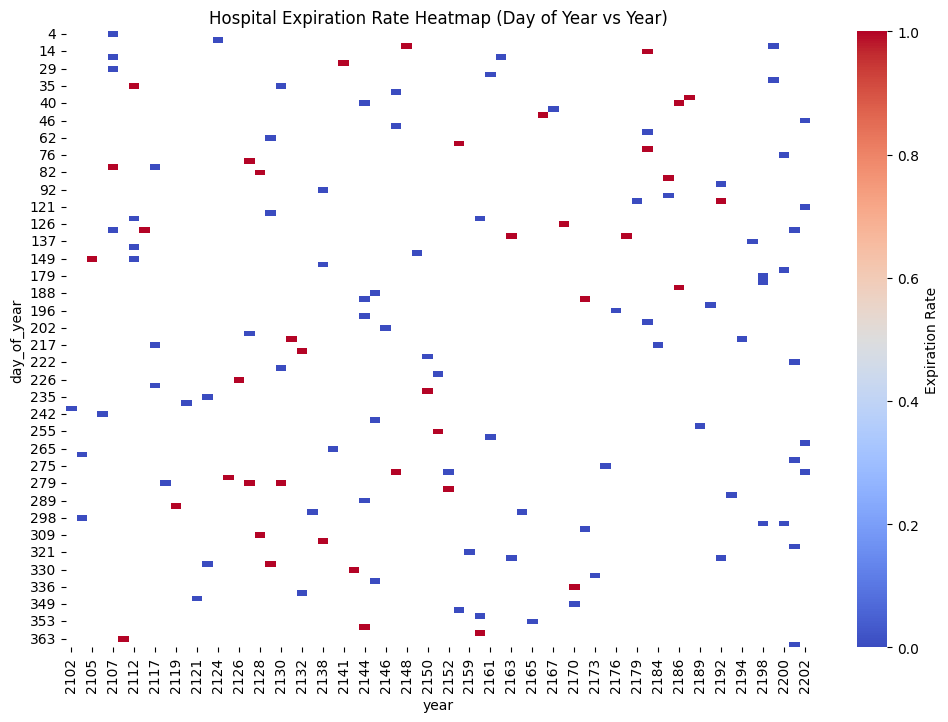

   season  Total Patients  Expired Patients  Percent Mortality Rate (%)
0  Winter              32                13                   40.625000
1  Spring              23                 6                   26.086957
2  Summer              34                 7                   20.588235
3    Fall              40                14                   35.000000


In [7]:
df_c['year'] = pd.to_datetime(df_c['admittime']).dt.year
df_c['month'] = pd.to_datetime(df_c['admittime']).dt.month
df_c['day_of_year'] = pd.to_datetime(df_c['admittime']).dt.dayofyear
df_c['season'] = pd.cut(df_c['month'], bins=[0, 3, 6, 9, 12], 
                        labels=['Winter', 'Spring', 'Summer', 'Fall'], 
                        include_lowest=True)
day_year_pivot = df_c.pivot_table(index='day_of_year', columns='year', values='hospital_expire_flag', aggfunc='mean')

seasonal_expire_rate_yearly = df_c.groupby(['year', 'season'], observed = False)['hospital_expire_flag'].mean().reset_index()
seasonal_expire_rate = df_c.groupby('season', observed = False)['hospital_expire_flag'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x='season', y='hospital_expire_flag', data=seasonal_expire_rate_yearly)
sns.lineplot(x = 'season', y = 'hospital_expire_flag', data = seasonal_expire_rate, color = 'red')
plt.title('Hospital Expiration Rate by Season')
plt.show()

plt.figure(figsize=(12,8))
sns.heatmap(day_year_pivot, cmap='coolwarm', cbar_kws={'label': 'Expiration Rate'})
plt.title('Hospital Expiration Rate Heatmap (Day of Year vs Year)')
plt.show()

seasonal_summary = df_c.groupby('season', observed = False).agg(
    total_patients=('hospital_expire_flag', 'size'),  # patients per season
    expired_patients=('hospital_expire_flag', 'sum')  # expired patients per season
).reset_index()
seasonal_summary['mortality_rate'] = (seasonal_summary['expired_patients'] / seasonal_summary['total_patients']) * 100

print(seasonal_summary[['season', 'total_patients', 'expired_patients', 'mortality_rate']].rename(
    columns={
        'total_patients': 'Total Patients',
        'expired_patients': 'Expired Patients',
        'mortality_rate': 'Percent Mortality Rate (%)'
    }
))

[no significant trends in season, can confirm by non-normal anovas (wilcox?)]

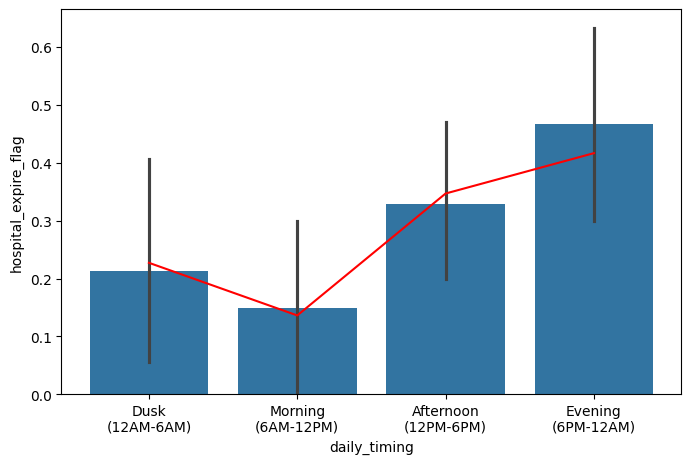

            daily_timing  Total Patients  Expired Patients  \
0       Dusk\n(12AM-6AM)              22                 5   
1    Morning\n(6AM-12PM)              22                 3   
2  Afternoon\n(12PM-6PM)              49                17   
3    Evening\n(6PM-12AM)              36                15   

   Percent Mortality Rate (%)  
0                   22.727273  
1                   13.636364  
2                   34.693878  
3                   41.666667  


In [19]:
df_c['hour'] = pd.to_datetime(df_c['admittime']).dt.hour
df_c['daily_timing'] = pd.cut(df_c['hour'], bins=[0, 6, 12, 18, 24], 
                        labels=['Dusk\n(12AM-6AM)', 'Morning\n(6AM-12PM)', 'Afternoon\n(12PM-6PM)', 'Evening\n(6PM-12AM)'], 
                        include_lowest=True)

daily_expire_rate_yearly = df_c.groupby(['year', 'daily_timing'], observed = False)['hospital_expire_flag'].mean().reset_index()
daily_expire_rate = df_c.groupby('daily_timing', observed = False)['hospital_expire_flag'].mean().reset_index()

plt.figure(figsize = (8,5))
sns.barplot(x = 'daily_timing', y = 'hospital_expire_flag', data = daily_expire_rate_yearly)
sns.lineplot(x = 'daily_timing', y = 'hospital_expire_flag', data = daily_expire_rate, color = 'red')
plt.show()

daily_summary = df_c.groupby('daily_timing', observed = False).agg(
    total_patients = ('hospital_expire_flag', 'size'),
    expired_patients = ('hospital_expire_flag', 'sum')
).reset_index()
daily_summary['mortality_rate'] = daily_summary['expired_patients'] / daily_summary['total_patients'] * 100

print(daily_summary[['daily_timing', 'total_patients', 'expired_patients', 'mortality_rate']].rename(
    columns={
        'total_patients': 'Total Patients',
        'expired_patients': 'Expired Patients',
        'mortality_rate': 'Percent Mortality Rate (%)'
    }
))

[trends about regarding afternoon and evening - admitted patients]

### Predictions of Patient Readmission

In [2]:
### What key features identify a patient as being high risk for readmission?

df_d = query_d()

print(df_d.head())
df_d.info()

   subject_id gender  age  hadm_id admission_type            admittime  \
0       10006      F   70   142345      EMERGENCY  2164-10-23 21:09:00   
1       10006      F   70   142345      EMERGENCY  2164-10-23 21:09:00   
2       10006      F   70   142345      EMERGENCY  2164-10-23 21:09:00   
3       10017      F   73   199207      EMERGENCY  2149-05-26 17:19:00   
4       10017      F   73   199207      EMERGENCY  2149-05-26 17:19:00   

             dischtime  hospital_expire_flag         diagnosis     los  \
0  2164-11-01 17:15:00                     0            SEPSIS  1.6325   
1  2164-11-01 17:15:00                     0            SEPSIS  1.6325   
2  2164-11-01 17:15:00                     0            SEPSIS  1.6325   
3  2149-06-03 18:42:00                     0  HUMERAL FRACTURE  2.1436   
4  2149-06-03 18:42:00                     0  HUMERAL FRACTURE  2.1436   

  curr_service transfer_type      transfer_intime     transfer_outtime  \
0          MED     discharge  2164-1

In [12]:
# TODO: determine patients that have readmission within 30 days and mark their previous visit as 1 in readmission within 30 days
# TODO: split dataset into training + validation
# TODO: create models and test them!!

NameError: name 'configure_db' is not defined

gonna make a ML model that assess whether a patient is likely for readmission given certain features about them

random forest? logistic regression? whata re some other models I can look at? // elbow test ... (specific diagnoses <- male patient comes in at 3pm on saturday, what is the highest likelihood for this to be classified as --> corr not caus) ** looking for one big bend

## Results and Discussion

[more words go here]